In [373]:
import numpy as np
import matplotlib.pyplot as plt
from pricing import EquityForwardCurve, ForwardVariance, DiscountingCurve,piecewise_function,Vanilla_PayOff,PricingModel, piecewise_function
from numpy import exp, sqrt, log
from scipy.interpolate import interp1d
import lets_be_rational.LetsBeRational as lbr
import time, sys
from montecarlo import MC_Analisys, MC
from matplotlib import ticker
from scipy.integrate import quad
from targetvol import time_grid_union, Drift, CholeskyTDependent, Strategy,TVSForwardCurve ,TargetVolatilityStrategy,Markowitz_solution,loss_function
from numpy.linalg import cholesky

In [374]:
def quad_piecewise(f, time_grid, t_in, t_fin, vectorial=0):
    """integral of a piecewise constant function"""
    dt = np.array([])
    if t_in == t_fin:
        return 0
    if t_fin in time_grid:
        time_grid = time_grid[np.where(time_grid<=t_fin)[0]]
    if t_in in time_grid:
        time_grid = time_grid[np.where(time_grid>=t_in)[0]]
    if t_in not in time_grid:
        time_grid = time_grid[np.where(time_grid>t_in)[0]]
        time_grid = np.insert(time_grid,0,t_in)
    if t_fin not in time_grid:
        time_grid = time_grid[np.where(time_grid<t_fin)[0]]
        time_grid = np.insert(time_grid,len(time_grid),t_fin)
    if vectorial:
        y = np.array([])
        for i in range(len(time_grid)-1):
            y = np.append(y,f(time_grid[i]))
    else:
        y = f(time_grid[:-1])
    dt = np.diff(time_grid)
    return np.sum(y*dt)

In [375]:


def quad_piecewise(f, time_grid, t_in, t_fin, vectorial=0):
    """integral of a piecewise constant function"""
    dt = np.array([])
    if t_in == t_fin:
        return 0
    if t_fin in time_grid:
        time_grid = time_grid[np.where(time_grid<=t_fin)[0]]
    if t_in in time_grid:
        time_grid = time_grid[np.where(time_grid>=t_in)[0]]
    if t_in not in time_grid:
        time_grid = time_grid[np.where(time_grid>t_in)[0]]
        time_grid = np.insert(time_grid,0,t_in)
    if t_fin not in time_grid:
        time_grid = time_grid[np.where(time_grid<t_fin)[0]]
        time_grid = np.insert(time_grid,len(time_grid),t_fin)
    if vectorial:
        y = np.array([])
        for i in range(1,len(time_grid)):
            y = np.append(y,f(time_grid[i]))
    else:
        y = f(time_grid[:-1])
      
    dt = np.diff(time_grid)
    return np.sum(y*dt)



def quad_piecewise_old(f, time_grid, t_in, t_fin):
    """integral of a piecewise constant function"""
    y = np.array([])
    dt = np.array([])
    if t_in == t_fin:
        return 0
    if t_fin in time_grid:
        time_grid = time_grid[np.where(time_grid<=t_fin)[0]]
    if t_in in time_grid:
        time_grid = time_grid[np.where(time_grid>=t_in)[0]]
    if t_in not in time_grid:
        time_grid = time_grid[np.where(time_grid>t_in)[0]]
        time_grid = np.insert(time_grid,0,t_in)
    if t_fin not in time_grid:
        time_grid = time_grid[np.where(time_grid<t_fin)[0]]
        time_grid = np.insert(time_grid,len(time_grid),t_fin)
    for i in range(len(time_grid)-1):
        y = np.append(y,f(time_grid[i]))
    dt = np.diff(time_grid)
    return np.sum(y*dt)

In [376]:
def quad_fast(f, time_grid, t_in, t_fin, vectorial=0)

SyntaxError: invalid syntax (<ipython-input-376-03e31f7e5f84>, line 1)

#### Test with a simple step function

In [377]:
T = np.array([0,1,2,3,4.5])
step = np.array([0.2,0.3,0.24,0.7,0.5])
f = interp1d(T,step, kind='previous',fill_value="extrapolate", assume_sorted=False)

In [378]:
%%time
x = np.linspace(0.1,5,20)
my = np.array([])
#theo = np.array([])
for i in x:
    my = np.append(my,quad_piecewise(f,T,0,i))
   # theo = np.append(theo, quad(f,0,i,limit=500)[0])
    
#plt.scf, time_grid, t_in, t_fin, vectorial=0atter(x,abs(my-theo))
plt.show()

CPU times: user 9.68 ms, sys: 234 µs, total: 9.92 ms
Wall time: 9.91 ms


In [379]:
%%time
x = np.linspace(0.1,5,20)
#my = np.array([])
theo = np.array([])
for i in x:
#    my = np.append(my,quad_piecewise(f,T,0,i))
    theo = np.append(theo, quad(f,0,i,limit=500)[0])
    
#plt.scatter(x,abs(my-theo))
plt.show()

CPU times: user 1.33 s, sys: 36.3 ms, total: 1.36 s
Wall time: 1.3 s


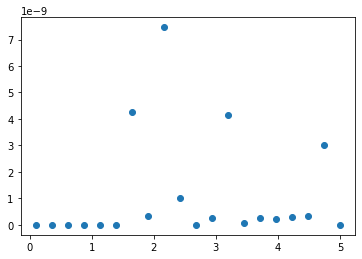

CPU times: user 2.15 s, sys: 27.7 ms, total: 2.17 s
Wall time: 2.12 s


In [380]:
%%time
T = np.array([1,2,3,4.5,6])
step = np.array([0.2,0.3,0.24,0.7,0.5])

f = lambda x: piecewise_function(x,T,step)
x = np.linspace(0.1,5,20)
my = np.array([])
theo = np.array([])
for i in x:
    my = np.append(my,quad_piecewise_old(f,T,0,i))
    theo = np.append(theo, quad(f,0,i,limit=500)[0])
    
plt.scatter(x,abs(my-theo))
plt.show()

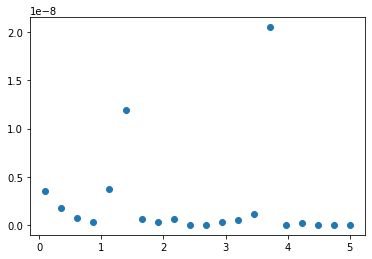

CPU times: user 1.76 s, sys: 32.3 ms, total: 1.79 s
Wall time: 1.74 s


In [381]:
%%time
x = np.linspace(0.1,5,20)
my = np.array([])
theo = np.array([])
f = interp1d(T,step, kind='previous',fill_value="extrapolate", assume_sorted=False)
for i in x:
    my = np.append(my,quad_piecewise(f,T,i,6))
    theo = np.append(theo, quad(f,i,6,limit=500)[0])
    
plt.scatter(x,abs(my-theo))
plt.show()

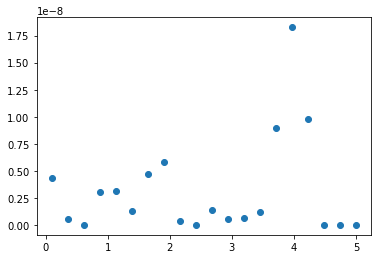

CPU times: user 2.35 s, sys: 47.3 ms, total: 2.4 s
Wall time: 2.36 s


In [382]:
%%time
x = np.linspace(0.1,5,20)
my = np.array([])
theo = np.array([])
f = lambda x: piecewise_function(x,T,step)
for i in x:
    my = np.append(my,quad_piecewise_old(f,T,i,6))
    theo = np.append(theo, quad(f,i,6,limit=500)[0])
    
plt.scatter(x,abs(my-theo))
plt.show()

#### Test with a complex step function

In [365]:
N_equity = 4                                #number of equities
T_max = 10
t = 0.                                      #pricing date
spot_price = np.array([110,120,97,133])            #spot price of the two assets
corr = np.array(([1,0.15,0.10,0.20],[0.15,1.,-0.05,0.18],[0.1,-0.05,1.,0.13],[0.20,0.18,0.13,1]))       #correlation matrix
minus = 1
"""Market Discount factors"""
r_t = np.array([1,1,1.9,1.2])/100            
T_discounts = np.array([0.,3,6.,T_max])      #data observation of the market discounts factor
market_discounts = exp(-r_t*T_discounts)       #market discounts factor

"""Market repo rates"""  #https://tradingeconomics.com/united-states/repo-rate
T_repo1 = np.array([2,6,T_max])       #data observation of the market repo rates for equity 1
repo_rate1 = minus*np.array([0.32,0.35,0.33])/100  #market repo rates for equity 1


T_repo2 = np.array([3.,6.,T_max])
repo_rate2 = minus*np.array([0.21,0.2,0.25])/100

T_repo3 = np.array([2.,5.,T_max])
repo_rate3 = minus*np.array([0.1,0.17,0.199])/100

T_repo4 = np.array([5,T_max])
repo_rate4 = minus*np.array([0.2,0.24])/100


for i in range(N_equity):                   #dimensional check between time and market data
    a = globals()["repo_rate" + str(i+1)]
    b = globals()["T_repo" + str(i+1)]
    if(a.shape!=b.shape):
        raise Exception("WARNING: Different dimension between data and value for repo rates of asset "+str(i+1))
        
"""Spot Volatilities"""
sigma1 = np.array([20,20.6,22])/100
T_sigma1 = np.array([2,5.,T_max])
K1 = np.array([spot_price[0],200])
spot_vola1 = np.array((sigma1,sigma1))                                      #market implied volatility matrix

sigma2 = np.array([30,31,32.62])/100
T_sigma2 =  np.array([2.,6,T_max])
K2 = np.array([spot_price[1],200])
spot_vola2 = np.array((sigma2,sigma2))  

sigma3 = np.array([25,23,22])/100
T_sigma3 = np.array([3,7.,T_max])
K3 = np.array([spot_price[2],200])
spot_vola3 = np.array((sigma3,sigma3))  

sigma4 = np.array([15,16,14])/100
T_sigma4 =  np.array([2,6.,T_max])
K4 = np.array([spot_price[3],200])
spot_vola4 = np.array((sigma4,sigma4))  

for i in range(N_equity):                   #dimensional check between time and market data
    a = globals()["sigma" + str(i+1)]
    b = globals()["T_sigma" + str(i+1)]
    if(a.shape!=b.shape):
        raise Exception("WARNING: Different dimension between data and value for volatility of asset "+str(i+1))
        
D = DiscountingCurve(reference=t, discounts=market_discounts,dates=T_discounts)
F = np.array([])
V = np.array([])
for i in range(N_equity):
    q = globals()["repo_rate" + str(i+1)]
    T_q = globals()["T_repo" + str(i+1)]
    s_vola = globals()["spot_vola" + str(i+1)]
    T_vola = globals()["T_sigma" + str(i+1)]
    K = globals()["K" + str(i+1)]
    F = np.append(F,EquityForwardCurve(reference=t,spot=spot_price[i],discounting_curve=D,repo_dates=T_q,repo_rates=q))
    V = np.append(V,ForwardVariance(reference=t,spot_volatility=s_vola,strikes=K,maturities=T_vola,strike_interp=spot_price[i]))

zero interest rate time grid [ 0.  3.  6. 10.]
zero interest rate:  [0.01  0.01  0.019 0.012]
Forward repo time grid [0. 2. 6.]
Forward repo rate:  [0.0032  0.00365 0.003  ]
Forward volatility time grid:  [0. 2. 5.]
Forward volatility:  [0.2        0.20990474 0.23316089]
Forward repo time grid [0. 3. 6.]
Forward repo rate:  [0.0021  0.0019  0.00325]
Forward volatility time grid:  [0. 2. 6.]
Forward volatility:  [0.3        0.31488093 0.34909325]
Forward repo time grid [0. 2. 5.]
Forward repo rate:  [0.001      0.00216667 0.00228   ]
Forward volatility time grid:  [0. 3. 7.]
Forward volatility:  [0.25       0.21377558 0.19467922]
Forward repo time grid [0. 5.]
Forward repo rate:  [0.002  0.0028]
Forward volatility time grid:  [0. 2. 6.]
Forward volatility:  [0.15       0.16477257 0.1029563 ]


In [366]:
mu = Drift(F)
nu = CholeskyTDependent(V,corr)
alpha = Strategy()
alpha.Mark_strategy(mu=mu,nu=nu)
I_0 = np.sum(spot_price)
vol_target = 1/N_equity*sqrt(np.sum(nu(0.)@nu(0.).T))
print("Target volatility: ",vol_target)
dates = alpha.T
dates = np.delete(dates,len(alpha.T)-1)
dates = np.append(dates,9.9)
K = I_0   #ATM pricing
simulations = 1e6
kind = 1 #call option
print("Spot price ",I_0)
print("Dates ",dates)

Drift time grid: [0. 2. 3. 5. 6.]
Drift values: [[0.0032     0.0021     0.001      0.002     ]
 [0.00365    0.0021     0.00216667 0.002     ]
 [0.00365    0.0019     0.00216667 0.002     ]
 [0.00365    0.0019     0.00228    0.0028    ]
 [0.003      0.00325    0.00228    0.0028    ]]
Cholesky covariance-variance time grid: [0. 2. 3. 5. 6. 7.]
Cholesky covariance-variance matrix values: [[[ 0.2         0.20990474  0.20990474  0.23316089  0.23316089
    0.23316089]
  [ 0.          0.          0.          0.          0.
    0.        ]
  [ 0.          0.          0.          0.          0.
    0.        ]
  [ 0.          0.          0.          0.          0.
    0.        ]]

 [[ 0.045       0.04723214  0.04723214  0.04723214  0.05236399
    0.05236399]
  [ 0.2966058   0.31131837  0.31131837  0.31131837  0.34514361
    0.34514361]
  [ 0.          0.          0.          0.          0.
    0.        ]
  [ 0.          0.          0.          0.          0.
    0.        ]]

 [[ 0.025       

In [387]:
T = np.array([1,2])
alpha(T[1])@mu(T[1])

-0.02067359068160313

In [388]:
alpha(T).shape

(2, 4)

In [389]:
np.sum(alpha(T)*mu(T),axis=1)

array([-0.01936018, -0.02067359])

In [390]:
nu(T).shape

(4, 4, 2)

In [391]:
i=0
alpha(T[i])@nu(T[i])

array([-0.82643877, -0.24032013, -0.14077714, -0.48931277])

In [392]:
np.sum((alpha(T)[0]*nu(T)[:,:,0].T),axis=1)

array([-0.82643877, -0.24032013, -0.14077714, -0.48931277])

In [395]:
nu(T)[:,:,0]

array([[ 0.2       ,  0.        ,  0.        ,  0.        ],
       [ 0.045     ,  0.2966058 ,  0.        ,  0.        ],
       [ 0.025     , -0.01643596,  0.24820326,  0.        ],
       [ 0.03      ,  0.02275748,  0.01812644,  0.14406085]])

In [393]:
alpha(T).T*nu(T)

array([[[-0.69103436, -0.71069064],
        [-0.        , -0.        ],
        [-0.        , -0.        ],
        [-0.        , -0.        ]],

       [[-0.15548273, -0.15991749],
        [-0.16826799, -0.16191855],
        [-0.        , -0.        ],
        [-0.        , -0.        ]],

       [[-0.08637929, -0.08464442],
        [ 0.00932431,  0.00854844],
        [-0.07920943, -0.30530501],
        [-0.        , -0.        ]],

       [[-0.10365515, -0.11157664],
        [-0.01291059, -0.01300198],
        [-0.00578471, -0.02449247],
        [-0.48931277, -0.36066032]]])

In [397]:
nu(T)[:,:,0].T

array([[ 0.2       ,  0.045     ,  0.025     ,  0.03      ],
       [ 0.        ,  0.2966058 , -0.01643596,  0.02275748],
       [ 0.        ,  0.        ,  0.24820326,  0.01812644],
       [ 0.        ,  0.        ,  0.        ,  0.14406085]])

In [408]:
matrix = nu(T)
matrix.shape

(4, 4, 2)

In [409]:
np.transpose(matrix).shape

(2, 4, 4)

In [413]:
np.transpose(matrix)

array([[[ 0.2       ,  0.045     ,  0.025     ,  0.03      ],
        [ 0.        ,  0.2966058 , -0.01643596,  0.02275748],
        [ 0.        ,  0.        ,  0.24820326,  0.01812644],
        [ 0.        ,  0.        ,  0.        ,  0.14406085]],

       [[ 0.20990474,  0.04723214,  0.025     ,  0.03295451],
        [ 0.        ,  0.31131837, -0.01643596,  0.02499872],
        [ 0.        ,  0.        ,  0.24820326,  0.0199116 ],
        [ 0.        ,  0.        ,  0.        ,  0.15824851]]])

In [336]:
0.69+0.15+0.07+0.1

1.01

In [322]:
nu(T).shape

(4, 4, 2)

In [227]:
np.sum(alpha(T[i])*nu(T[i]).T,axis=1)

array([-0.82643877, -0.24032013, -0.14077714, -0.48931277])

In [261]:
i=1
alpha(T[i])*nu(T[i]).T

array([[-0.71069064, -0.02456572, -0.03075151, -0.07510583],
       [-0.        , -0.16191855,  0.02021722, -0.05697398],
       [-0.        , -0.        , -0.30530501, -0.04538004],
       [-0.        , -0.        , -0.        , -0.36066032]])

In [428]:
np.linalg.norm(np.sum((alpha(T).T*nu(T).transpose(1,0,2)),axis=1).T,axis=1)

array([1., 1.])

In [422]:
nu(T[0]).T

array([[ 0.2       ,  0.045     ,  0.025     ,  0.03      ],
       [ 0.        ,  0.2966058 , -0.01643596,  0.02275748],
       [ 0.        ,  0.        ,  0.24820326,  0.01812644],
       [ 0.        ,  0.        ,  0.        ,  0.14406085]])

In [425]:
nu(T).transpose(1,0,2)[:,:,0]

array([[ 0.2       ,  0.045     ,  0.025     ,  0.03      ],
       [ 0.        ,  0.2966058 , -0.01643596,  0.02275748],
       [ 0.        ,  0.        ,  0.24820326,  0.01812644],
       [ 0.        ,  0.        ,  0.        ,  0.14406085]])

In [285]:
(alpha(T).T*nu(T))

array([[[-0.69103436, -0.71069064],
        [-0.        , -0.        ],
        [-0.        , -0.        ],
        [-0.        , -0.        ]],

       [[-0.15548273, -0.15991749],
        [-0.16826799, -0.16191855],
        [-0.        , -0.        ],
        [-0.        , -0.        ]],

       [[-0.08637929, -0.08464442],
        [ 0.00932431,  0.00854844],
        [-0.07920943, -0.30530501],
        [-0.        , -0.        ]],

       [[-0.10365515, -0.11157664],
        [-0.01291059, -0.01300198],
        [-0.00578471, -0.02449247],
        [-0.48931277, -0.36066032]]])

In [250]:
np.sum((alpha(T).T*nu(T).T.T).T[0].T,axis=)

array([-0.69103436, -0.32375072, -0.15626441, -0.61166322])

In [218]:
alpha(T).shape,nu(T).shape

((2, 4), (4, 4, 2))

In [236]:
nu(T).T.T.shape

(4, 4, 2)

In [239]:
np.sum(alpha(T).T*nu(T).T.T,axis=0)

array([[-1.03655154, -1.06682919],
       [-0.17185426, -0.1663721 ],
       [-0.08499414, -0.32979748],
       [-0.48931277, -0.36066032]])

In [295]:
a = np.array(([5,1,7],[3,3,3]))
b = np.array([[[1,1,1],[1,1,1]],[[1,1,1],[1,1,1]]])

In [296]:
b = np.array(([2,2,2],[2,2,2],[2,2,2]))
c = b/2
d = np.array((b,c)).T

In [314]:
a.shape

(2, 3)

In [315]:
d.shape

(3, 3, 2)

In [301]:
np.sum((a.T*d).T[1],axis=0)

array([9., 9., 9.])

In [302]:
a[1]@b

array([18, 18, 18])

In [185]:
alpha(T).T*nu(T)

array([[[-0.69103436, -0.71069064],
        [-0.        , -0.        ],
        [-0.        , -0.        ],
        [-0.        , -0.        ]],

       [[-0.15548273, -0.15991749],
        [-0.16826799, -0.16191855],
        [-0.        , -0.        ],
        [-0.        , -0.        ]],

       [[-0.08637929, -0.08464442],
        [ 0.00932431,  0.00854844],
        [-0.07920943, -0.30530501],
        [-0.        , -0.        ]],

       [[-0.10365515, -0.11157664],
        [-0.01291059, -0.01300198],
        [-0.00578471, -0.02449247],
        [-0.48931277, -0.36066032]]])

In [161]:
np.sum((alpha(T).T*nu(T)).T,axis=1)

array([[-0.69103436, -0.32375072, -0.15626441, -0.61166322],
       [-0.71069064, -0.32183604, -0.381401  , -0.50973141]])

In [136]:
alpha(T)@nu(T)

array([[[-0.69103436, -0.72525694],
        [-0.6771554 , -0.71069064]],

       [[-0.32375072, -0.33980976],
        [-0.30662642, -0.32183604]],

       [[-0.15626441, -0.15626441],
        [-0.381401  , -0.381401  ]],

       [[-0.61166322, -0.67190215],
        [-0.4640318 , -0.50973141]]])

In [442]:
g = lambda x: vol_target*np.sum(alpha(x)*mu(x),axis=1)/np.linalg.norm(np.sum((alpha(x).T*nu(x).transpose(1,0,2)),axis=1).T,axis=1)

In [443]:
g(np.array([0.]))

array([-0.00253098])

In [444]:
l(0.)

-0.002530977423157284

In [448]:
a= quad_piecewise(g,alpha.T,0.,1.,vectorial=0)

In [449]:
b=quad_piecewise(l,alpha.T,0.,1.,vectorial=1)

In [450]:
a-b

-4.336808689942018e-19

In [141]:
np.sum(np.sum(alpha(T)@nu(T),axis=1),axis=1)

array([-2.80413733, -1.29202294, -1.07533081, -2.25732858])

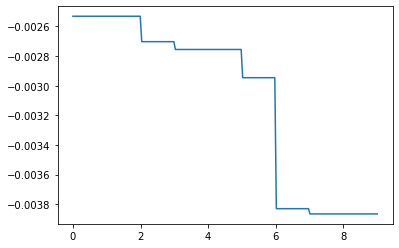

In [433]:
l = lambda x: vol_target*((alpha(x)@mu(x))/np.linalg.norm(alpha(x)@nu(x)))

y = np.linspace(0,9,200)
f = np.array([])
for i in y:
    f = np.append(f,l(i))
plt.plot(y,f)
plt.show()

In [354]:
my=quad_piecewise(l,alpha.T,0.,1.,vectorial=1)

In [38]:
%%time
print(alpha.T)
a = 0
b = 9.
my=quad_piecewise(l,alpha.T,a,b,vectorial=1)
theo = quad(l,a,b, limit=500)[0]
print("my integration ",my)
print("quad integration",theo)
print("difference ",abs(my - theo))

[0. 2. 3. 5. 6. 7.]
my integration  -0.027784960280329275
quad integration -0.027784960280329292
difference  1.734723475976807e-17
CPU times: user 586 ms, sys: 73.7 ms, total: 660 ms
Wall time: 566 ms


[0.1        0.56842105 1.03684211 1.50526316 1.97368421 2.44210526
 2.91052632 3.37894737 3.84736842 4.31578947 4.78421053 5.25263158
 5.72105263 6.18947368 6.65789474 7.12631579 7.59473684 8.06315789
 8.53157895 9.        ]
[0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 6.32478539e-10 1.54000736e-08 1.05966231e-07
 7.90094327e-11 1.89630460e-09 2.52123445e-09 1.27068233e-09
 9.76123279e-11 3.48900531e-09 2.85592001e-11 8.77067540e-10
 2.58787338e-09 6.21759626e-10 1.64230896e-09 1.73472348e-17]


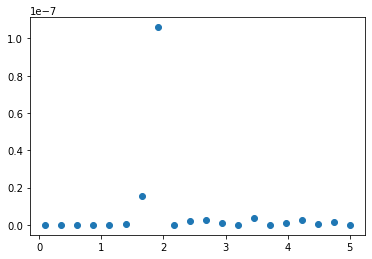

CPU times: user 6.05 s, sys: 102 ms, total: 6.15 s
Wall time: 6.16 s


In [41]:
%%time
y = np.linspace(0.1,9.,20)
print(y)
my = np.array([])
theo = np.array([])
for i in y:
    my = np.append(my,quad_piecewise(l,alpha.T,0,i,vectorial=1))
    theo = np.append(theo, quad(l,0,i,limit=500)[0])
    
plt.scatter(x,abs(my-theo))
print(abs(my-theo))
plt.show()